# APMTH 207: Advanced Scientific Computing:
## Stochastic Methods for Data Analysis, Inference and Optimization
## Solutions to Homework #8

**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 30th, 2018 at 11:00am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [81]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import uniform
from scipy.stats import gamma
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

from sklearn.model_selection import train_test_split
import pymc3 as pm
from pymc3 import Model, Normal, Bernoulli, find_MAP, sample, traceplot
import warnings
warnings.filterwarnings('ignore')
import theano.tensor as t
from theano import shared

from tqdm import tqdm

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)




## Problem 1: Understanding Yelp Review Data As a Human
In this course, we've spent a lot of time learning algorithms for performing inference on complex models and we've spent time using these models to make decisions regarding our data. But in nearly every assignment, the model for the data is specified in the problem statement. In real life, the creative and, arguably, much more difficult task is to start with a broadly defined goal and then to customize or create a model which will meet this goal in some way. 



Problem #1 is atypical in that it does not involve any programming or (necessarily) difficult mathematics/statistics. The process of answering these questions *seriously* will however give you an idea of how one might create or select a model for a particular application and your answers will help you with formalizing the model if and when you're called upon to do so.

***Grading:*** *We want you to make a genuine effort to mold an ambiguous and broad real-life question into a concrete data science or machine learning problem without the pressure of getting the "right answer". As such, we will grade your answer of Problem #1 on a pass/fail basis. Any reasonable answer that demonstrates actual effort will be given a full grade.*

We've compiled for you a fairly representative selection of [Yelp reviews](./yelp_reviews.zip) for a (now closed) sushi restaurant called Ino's Sushi in San Francisco. Read the reviews and form an opinion regarding the various qualities of Ino's Sushi. Answer the following:

1. If the task is to summarize the quality of a restaurant in a simple and intuitive way, what might be problematic with simply classifying this restaurant as simply "good" or "bad"? Justify your answers with specific examples from the dataset.

2. For Ino's Sushi, categorize the food and the service, separately, as "good" or "bad" based on all the reviews in the dataset. Be as systematic as you can when you do this.

  (**Hint:** Begin by summarizing each review. For each review, summarize the reviewer's opinion on two aspects of the restaurant: food and service. That is, generate a classification ("good" or "bad") for each aspect based on what the reviewer writes.) 
  
3. Identify statistical weaknesses in breaking each review down into an opinion on the food and an opinion on the service. That is, identify types of reviews that make your method of summarizing the reviewer's optinion on the quality of food and service problemmatic, if not impossible. Use examples from your dataset to support your argument. 

4. Identify all the ways in which the task in #2 might be difficult for a machine to accomplish. That is, break down the classification task into simple self-contained subtasks and identify how each subtask can be accomplished by a machine (i.e. which area of machine learning, e.g. topic modeling, sentiment analysis etc, addressess this type of task).

5. Describe a complete pipeline for processing and transforming the data to obtain a classification for both food and service for each review.

## Problem 2: My Sister-In-Law's Baby Cousin Tracy ...


Wikipedia describes the National Annenberg Election Survey as follows -- "National Annenberg Election Survey (NAES) is the largest academic public opinion survey conducted during the American presidential elections. It is conducted by the Annenberg Public Policy Center at the University of Pennsylvania."  In the file [survey.csv](./survey.csv) we provide the following data from the 2004 National Annenberg Election Survey:  `age` -- the age of the respondents, `numr` -- the number of responses, and `knowlgbtq` -- the number of people at the given age who have at least one LGBTQ acquaintance.  We want you to model how age influences likelihood of interaction with members of the LGBTQ community in three ways. 


1. Using pymc3, create a bayesian regression model (either construct the model directly or use the glm module) with the same feature and dependent variable. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

2. Using pymc3, create a 1-D Gaussian Process regression model with the same feature and dependent variables.  Use a squared exponential covariance function. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

3. How do the models compare? Does age influence likelihood of acquaintance with someone LGBTQ? For Bayesian Linear Regression and GP Regression, how does age affect the variance of the estimates?

For GP Regression, we can model the likelihood of knowing someone LGBTQ as a product of binomials -- one binomial distribution per age group. 

$$p(y_a | \theta_a, n_a) = Binom( y_a, n_a, \theta_a)$$

where $y_a$ (i.e. `knowlgbtq`) is the observed number of respondents who know someone lgbtq  at age $a$, $n_a$ (i.e. `numr`) is the number of trials and $\theta_a$ is the rate parameter for having an lgbtq acquaintance at age $a$.

Using the Gaussian approximation  (http://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation) to approximate the Binomial since `numr` is large, you can simply use a GP posterior with the error for each measurement to be given using this approximation. 

**Solution**

We'll start by importing our count data into pandas and doing some basic EDA.

In [2]:
survey = pd.read_csv("survey.csv")

ages = np.array(survey['age'])
know_lgbtq_rate = survey['knowlgbtq'] / survey['numr']
know_lgbtq_rate = np.array(know_lgbtq_rate)
resp = survey['numr']

In [3]:
survey.head()

,age,numr,knowlgbtq
0,18,310,158
1,19,221,118
2,20,217,120
3,21,255,131
4,22,301,168


Text(0,0.5,'Proportion of Individuals \nwith LGBTQ Acquaintance')

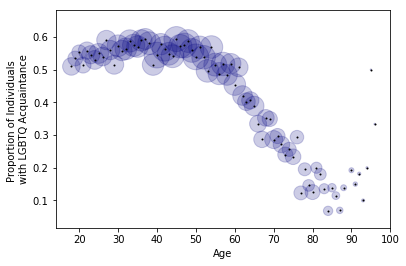

In [4]:
plt.scatter(ages, know_lgbtq_rate, s=resp, c='navy', alpha=0.2)
plt.scatter(ages, know_lgbtq_rate, s=1, c='black')
plt.xlabel('Age')
plt.ylabel('Proportion of Individuals \nwith LGBTQ Acquaintance')

**1. Using pymc3, create a bayesian regression model (either construct the model directly or use the glm module) with the same feature and dependent variable. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.**

In [ ]:
simple_glm_data = dict(x=ages, y=know_lgbtq_rate)


with pm.Model() as simple_glm_model:
    pm.glm.GLM.from_formula('y ~ x', simple_glm_data)
    
with simple_glm_model:
    lgbtq_trace = pm.sample(10000)

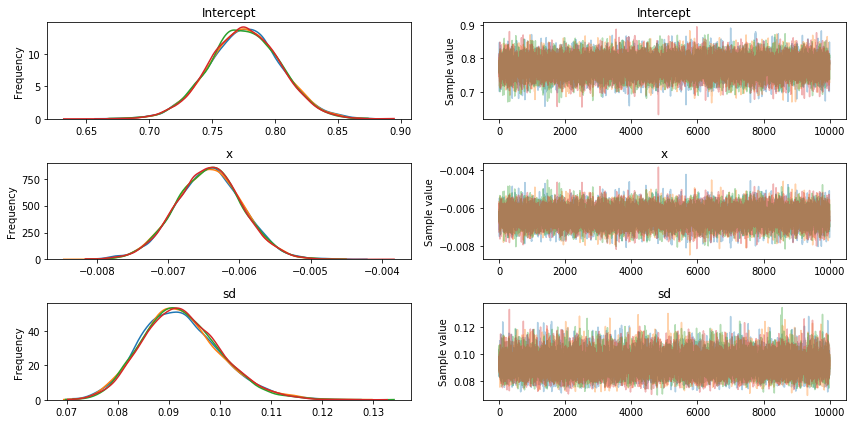

In [91]:
pm.traceplot(lgbtq_trace);

Traceplot looks ok.  Let's check autocorrelation.

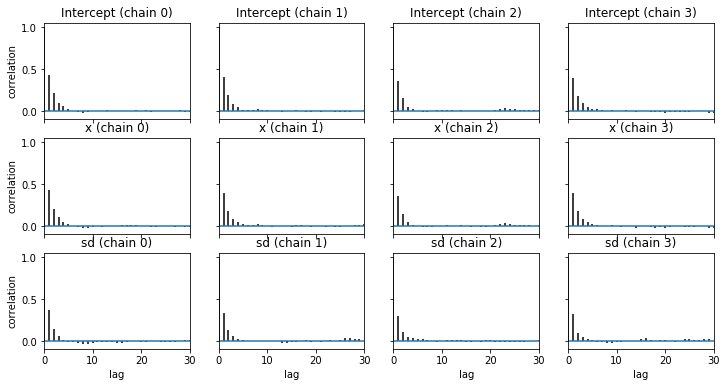

In [90]:
pm.autocorrplot(lgbtq_trace, max_lag=30);

In [8]:
pm.gelman_rubin(lgbtq_trace)

{'Intercept': 0.9999565367652972,
 'x': 0.9999618888571224,
 'sd': 0.9999968634131177}

In [9]:
pm.diagnostics.effective_n(lgbtq_trace)

{'Intercept': 16270.0, 'x': 16300.0, 'sd': 19000.0}

Our diagnostics all seem ok.  Let's visualize posterior and take the ppc.

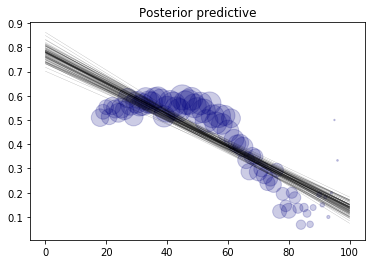

In [10]:
plt.scatter(ages, know_lgbtq_rate, s=resp, c='navy', alpha=0.2)
pm.plot_posterior_predictive_glm(lgbtq_trace, samples=100, eval=np.arange(0,101,1), alpha=0.5)

In [11]:
with simple_glm_model:
    lgbtq_ppc = pm.sample_ppc(lgbtq_trace, samples=500)

100%|██████████| 500/500 [00:00<00:00, 1548.34it/s]


In [12]:
new_ages=np.append(np.append(np.arange(0,18,1),ages),np.array((97,98,99,100)))

We'll create a custom ppc generator so we can create out of sample posterior predictive samples.  We'll maek sure it creates a similar data structure as sample_ppc

In [13]:
def generate_ppc(trace, data, samples=500, indices=[]):

    if samples < len(trace):
        indices = np.random.choice(len(trace),size=samples)
    else:
        indices = np.array(range(len(trace)))
    
    betas = [trace[i] for i in indices]
    
    ppc = []
    
    for x in tqdm(data):
        ys = [sp.stats.norm.rvs(loc=(beta['Intercept']+ x*beta['x']),scale=beta['sd']) for beta in betas]
        if ppc == []:
            ppc = np.array([ys]).T
        else:
            ppc=np.append(ppc, np.array([ys]).T, axis=1)
        
    return {'y': ppc }

Let's generate our out of sample posterior predictive samples

In [14]:
lgbtq_oos_ppc = generate_ppc(lgbtq_trace, new_ages, samples=500)

100%|██████████| 100/100 [00:01<00:00, 57.02it/s]


In [37]:
post_means = np.mean(lgbtq_oos_ppc['y'], axis=0)
post_std_devs = np.std(lgbtq_oos_ppc['y'], axis=0)

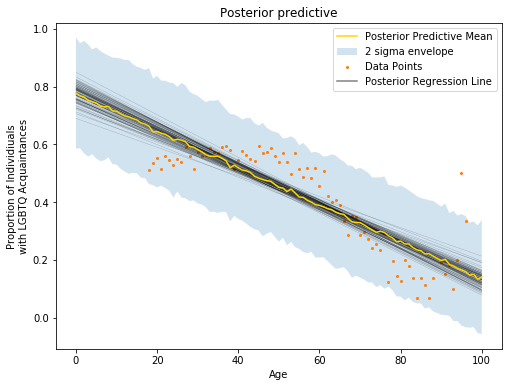

In [86]:
fig, ax = plt.subplots(figsize=(8,6))
pm.plot_posterior_predictive_glm(lgbtq_trace, samples=100, eval=np.arange(0,101,1), alpha=0.5)
ax.fill_between(new_ages, post_means-2*post_std_devs, post_means+2*post_std_devs,label="2 sigma envelope", alpha=0.2)
ax.plot(new_ages, post_means, label='Posterior Predictive Mean', color='gold')
ax.scatter(ages, know_lgbtq_rate, s=4, label='Data Points')
ax.set_xlabel('Age')
ax.set_ylabel('Proportion of Individiuals\nwith LGBTQ Acquaintances')

## Add custom legend
gray_line = mlines.Line2D([], [], alpha=0.5, color='black')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles+[gray_line], labels+ ['Posterior Regression Line']);

**2. Using pymc3, create a 1-D Gaussian Process regression model with the same feature and dependent variables.  Use a squared exponential covariance function. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.**

In [43]:
with pm.Model() as gp_model:
    
    # priors on the covariance function hyperparameters
    l = pm.HalfCauchy('l', beta=10)
    
    # uninformative prior on the function variance (some but not too much correlation between adjacent points)
    s2_f = pm.HalfCauchy('s2_f', beta=5)
    
    # uninformative prior on the noise variance (pretty small variance on noise)
    s2_n = pm.HalfCauchy('s2_n', beta=2)
    
    # covariance functions for the function f and the noise
    f_cov = s2_f**2 * pm.gp.cov.ExpQuad(1, l)
    
    mgp = pm.gp.Marginal(cov_func=f_cov)
    y_obs = mgp.marginal_likelihood('y_obs', X=ages.reshape(-1,1), y=know_lgbtq_rate, noise=s2_n, is_observed=True)

In [44]:
with gp_model:
    marginal_post = pm.find_MAP()

logp = 108.85, ||grad|| = 0.00034517: 100%|██████████| 23/23 [00:00<00:00, 337.35it/s]  


In [ ]:
with gp_model:
    gp_trace = pm.sample(10000, tune=2000, nuts_kwargs={'target_accept':0.85})


In [63]:
marginal_post

{'l_log__': array(3.18353738),
 's2_f_log__': array(-0.54559388),
 's2_n_log__': array(-3.15154798),
 'l': array(24.1319668),
 's2_f': array(0.57949753),
 's2_n': array(0.04278584)}

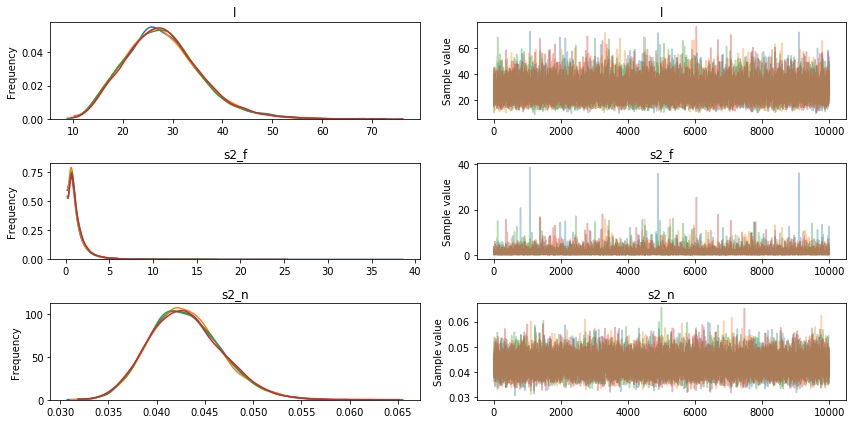

In [62]:
pm.traceplot(gp_trace);

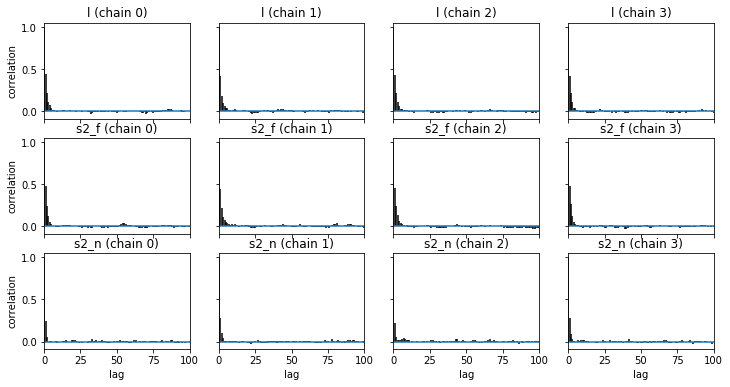

In [64]:
pm.autocorrplot(gp_trace);

Traces and autocorrelation look fine.  Seemingly the length and magnitude of correlation across datapoints remains pretty broad, but the magnitude of the variance due to noise is quite sharp.

In [48]:
with gp_model:
    fpred = mgp.conditional("fpred", new_ages.reshape(-1,1), pred_noise=False)
    ypred = mgp.conditional("ypred", new_ages.reshape(-1,1), pred_noise=True)
    gp_oos_ppc = pm.sample_ppc(gp_trace, vars=[fpred, ypred], samples=500)

100%|██████████| 500/500 [00:05<00:00, 86.18it/s]


In [51]:
gp_oos_means = np.mean(gp_oos_ppc['ypred'], axis=0)
gp_oos_std_devs = np.std(gp_oos_ppc['ypred'], axis=0)

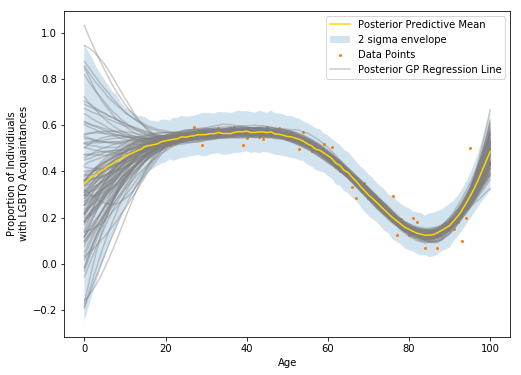

In [89]:
fig, ax = plt.subplots(figsize=(8,6))
ax.fill_between(new_ages, gp_oos_means-2*gp_oos_std_devs, gp_oos_means+2*gp_oos_std_devs,label="2 sigma envelope", alpha=0.2);
[ax.plot(new_ages, y, color="gray", alpha=0.4) for y in gp_oos_ppc['fpred'][::5,:]];
ax.plot(new_ages, gp_oos_means, label='Posterior Predictive Mean', color='gold')
ax.scatter(ages, know_lgbtq_rate, s=4, label='Data Points');
ax.set_xlabel('Age')
ax.set_ylabel('Proportion of Individiuals\nwith LGBTQ Acquaintances')

## Add custom legend
gray_line = mlines.Line2D([], [], alpha=0.4, color='gray')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles+[gray_line], labels+ ['Posterior GP Regression Line']);

**3. How do the models compare? Does age influence likelihood of acquaintance with someone LGBTQ? For Bayesian Linear Regression and GP Regression, how does age affect the variance of the estimates?**

Both GP Regression and Bayesian Linear Regression model the general trend of our data which is to say that the older you are the less likely that you are to have an LGBTQ acquaintance.  Bayesian Linear Regression (BLR) only captures the general trend whereas GP captures a more nuanced curved trendline.  Both GP and BLR are fairly constant in the uncertainty of their predictions over the ages for which data is reported.  This makes sense since as we aggregate the responses for each age, we have consistent data points over the age axis.  In the regions for which we don't have reported data (e.g age range 0-17), BLR does a very poor job of representing the increased uncertainty (the simple linear regression model is limited to more or less constant uncertainty in the posterior predictive distribution over the entirety of its domain) whereas GP Regression does an excellent job of representing increased uncertainty of prediction in regions without data with increased variance of the posterior predictive samples. Our GP Regression model also has lower variance in the regions with data.

## Problem 3:  Like a Punch to the Kidneys 

In this problem we will work with the US Kidney Cancer Dataset (by county), a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

The kidney cancer data can be found [here](./kcancer.csv).

A casual inspection of the data might suggest that we independently model cancer rates for each of the provided counties.  Our experience in past homeworks/labs/lectures (in particular when we delved into the Rat Tumors problem) suggests potential drawbacks of conclusions based on raw cancer rates.  Addressing these drawbacks, let's look use a Bayesian model for our analysis of the data. In particular you will implement an Empircal Bayes model to examine the adjusted cancer rates per county.

Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-th county and $\theta_j$ the underlying kidney cancer rate for that county. We can construct a Bayesian model for our data as follows:
\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}
where $\alpha, \beta$ are hyper-parameters of the model.

- (#1) Implement Empirical Bayes via moment matching as described as follows. Consider the **prior-predictive** distribution (also called the evidence i.e. the denominator normalization in bayes theorem) of the model: $p(y) = \int p(y \vert \theta) p(\theta) d \theta$. Why the prior-predictive? Because technically we "haven't seen" individual county data yet.  For this model, the prior-predictive is a negative binomial. Matching the mean and the variance of the negative binomial to that from the data, you can find appropriate expressions for $\alpha$ and $\beta$. (Hint: You need to be careful with the $5n_j$ multiplier.) 

- (#2) Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot add a scatter plot visualization of the posterior mean cancer rate estimates (pct mortality) vs the county population size, highlight these in green.

- (#3) Using the above scatter plot, explain why using the posterior means from our model to estimate cancer rates is preferable to studying the raw rates themselves.

(**Hint:** You might also find it helpful to follow the Rat Tumor example.)

(**Note:** Up until now we've had primarily thought about the posterior predictive: $\int p( y \vert \theta) p(\theta \vert D) d\theta$.  The posterior predictive and the prior predictive can be somewhat connected. In conjugate models such as ours, the two distributions have the same form.) 

**Solution:**

#### Question 1. Closed Forms for the Posterior and Predictive Distributions
We note that the Gamma-Poisson model is conjugate, that is, the posterior, posterior predictive and prior predictive all have closed forms. In particular, the posterior distribution is a Gamma distribution and the prior predictive is a Negative Binomial Distribution. Since the Poisson distribution 

\begin{align}
p(\theta_j | y_j) &\propto Poisson(y_j; 5 \cdot n_j \cdot \theta_j) Gamma(\theta_j; \alpha, \beta)\\
&\propto e^{-5 \cdot n_j \cdot \theta_j} \left(5 \cdot n_j \cdot \theta_j\right)^{y_j} \theta_j^{\alpha - 1} e^{-\beta\theta_j}\\
&= e^{-\left(5 \cdot n_j \cdot \theta_j + \beta\theta_j\right)} \theta_j^{\alpha + y_j - 1} \left(5 \cdot n_j\right)^{y_j}\\
&\propto e^{-\left(5 \cdot n_j  + \beta\right)\theta_j} \theta_j^{\alpha + y_j - 1}
\end{align}

We see that $p(\theta_j | y_j)$ is a Gamma distribution, $Gamma(\alpha + y_j, 5 n_j  + \beta)$.

Recall that the prior predictive, $p(y_j)$, can computed by
$$
p(y_j) = \frac{p(y_j | \theta_j) p(\theta_j)}{p(\theta_j | y_j)}.
$$
In our case, this becomes

\begin{align}
p(y_j) &= \frac{Poisson(y_j; 5 \cdot n_j \cdot \theta_j) Gamma(\theta_j; \alpha, \beta)}{Gamma(\alpha + y_j, 5 n_j  + \beta)}\\
&= \frac{\frac{1}{y_j!} e^{5 \cdot n_j \cdot \theta_j} \frac{\beta^\alpha}{\Gamma(\alpha)} \theta_j^{\alpha - 1} e^{-\beta\theta_j}}{\frac{\left(5 n_j  + \beta\right)^{\left( \alpha + y_j\right)}}{\Gamma\left(\alpha + y_j\right)} \theta_j^{\alpha + y_j - 1} e^{-\left(5 n_j  + \beta\right) \theta_j}}\\
&= \frac{\beta^\alpha\Gamma\left(\alpha + y_j\right)  \left(5 \cdot n_j\right)^{y_j} \theta_j^{\alpha + y_j - 1}e^{-\left(5 \cdot n_j  + \beta\right)\theta_j}}{y_j!\Gamma(\alpha) \left(5 n_j  + \beta\right)^{\left( \alpha + y_j\right)}\theta_j^{\alpha + y_j - 1} e^{-\left(5 n_j  + \beta\right) \theta_j}}\\
&= \frac{\beta^\alpha\Gamma\left(\alpha + y_j\right)  \left(5 \cdot n_j\right)^{y_j}}{y_j!\Gamma(\alpha) \left(5 n_j  + \beta\right)^{\left( \alpha + y_j\right)}}\\
&= \frac{\Gamma\left(\alpha + y_j\right)}{y_j!\Gamma(\alpha)}\frac{\beta^\alpha}{\left(5 n_j  + \beta\right)^{\alpha}} \frac{\left(5 \cdot n_j\right)^{y_j}}{\left(5 n_j  + \beta\right)^{y_j}}\\
&= \frac{\Gamma\left((\alpha + y_j - 1) + 1\right)}{y_j!\Gamma(\alpha)} \left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\
&= \frac{(\alpha + y_j - 1)\Gamma\left((\alpha + y_j - 2) - 1\right)}{y_j!\Gamma(\alpha)} \left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\ 
&\vdots\\
&= \frac{(\alpha + y_j - 1)!}{y_j!\Gamma(\alpha)}\left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\
&= \frac{(\alpha + y_j - 1)!}{y_j!(\alpha - 1)!}\left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}\\
&= \binom{\alpha + y_j - 1}{y_j}\left( \frac{\beta}{5 n_j  + \beta}\right)^\alpha \left( \frac{5 \cdot n_j}{5 n_j  + \beta}\right)^{y_j}
\end{align}

In the above, we've used the relation $\Gamma(n + 1) = n\Gamma(n)$ to obtain:

\begin{align}
\Gamma\left(\alpha + y_j\right) &= (\alpha + y_j - 1)!\\
\Gamma(\alpha) &= (\alpha - 1)!
\end{align}


Thus, $p(y_j)$ can be parametrized as $NegBin\left(\alpha, \frac{5 n_j}{1  + \beta}\right)$. From this, we can compute the mean and variance of $y_j$ as 
\begin{align}
\mathbb{E}[y_j] &= \frac{5 n_j \alpha }{\beta}\\
\mathrm{Var}[y_j]&= \frac{(5 n_j)^2\alpha}{\beta^2} + \frac{5 n_j\alpha}{\beta} 
\end{align}

#### Question 1. Calculating $\alpha, \beta$ via Empirical Bayes

Empirical Bayes refer to a class of methods wherein we choose values for our hyperparameters based on the data. There are a [number of ways you can do this](https://am207.github.io/2017/wiki/levelsofbayes.html). Typically, we choose a distribution involving the data and the hyperparameters, like the prior predictive, $p(y_j | \alpha, \beta)$, or the joint distribution of the data and the hyperparameters, $p(y_j, \alpha, \beta)$. We then seek  values of $\alpha$, $\beta$ that maximizes the "likelihood" of the data given by these functions. Note that maximizing $p(y_j | \alpha, \beta)$ and $p(y_j, \alpha, \beta)$ may be difficult (especially when these functions have multiple local optima). Thus, another approach is to estimate $\alpha$ and $\beta$ by performing moment matching. That is, we set the expectation and variance of these distributions to values computed from the data; using these equations we can solve for $\alpha$ and $\beta$. 

Unfortunately, obtaining an valid estimate of $\mathbb{E}[y_j]$ (and $\mathrm{Var}[y_j]$) requires us to have multiple samples of $y_j$, for a fixed $j$, and to average them. Instead, what we have are samples from different $y_j$'s (each from a different distribution). If we are permited to be a bit sloppy, we can treat the set of $y_j$ values are samples from the same distribution. That is, we simply set
\begin{align}
\bar{y}_j = \frac{1}{N}\sum^N_{j=1} y_j &= \mathbb{E}[y_j],\\
sample\_var[y_j]&= \mathrm{Var}[y_j].
\end{align}
If we want to be more precise, we'd want to adjust the number of deaths, $y_j$, in the $j$-th county, by the population of the county. That is, we set
\begin{align}
\overline{\frac{y_j}{n_j}} = \frac{1}{N}\sum^N_{j=1} \frac{y_j}{n_j} &= \frac{5 \alpha }{\beta},\\
sample\_var\left[\frac{y_j}{n_j}\right]= \frac{25\alpha}{\beta^2} + \frac{5\alpha}{n_j\beta} &= \overline{\frac{y_j}{n_j}} \left( \frac{5}{\beta} + \frac{1}{n_j}\right).
\end{align}
In order to make use of all of our data, we further substitute the empirical mean of the populatin, $\bar{n}_j$, for $n_j$.

In [4]:
df=pd.read_csv("kcancer.csv")
adjusted_y = df['dc'] / df['pop']
y_mean = np.mean(adjusted_y)
y_var = np.var(adjusted_y)
pop_mean = np.mean(df['pop'])
print('empirical cancer population adjusted mean: ', y_mean)
print('empirical cancer population adjusted var: ', y_var)
print('empirical population mean: ', pop_mean)

empirical cancer population adjusted mean:  5.786552354108626e-05
empirical cancer population adjusted var:  2.527523010812238e-09
empirical population mean:  160512.41021522647


Substituting the empirical values into the two equations above, we get:

\begin{align}
\mathtt{5.78655235411e-05}&= \frac{5\alpha }{\beta},\\
\mathtt{2.52752301081e-09}&= \mathtt{5.78655235411e-05}\left(\frac{5}{\beta} + \frac{1}{\mathtt{160512.410215}}\right).
\end{align}

Solving for $\alpha, \beta$, we get
\begin{align}
\alpha &= \frac{\mathtt{5.78655235411e-05}\cdot\beta}{5}\\
\beta &= \frac{5}{\frac{\mathtt{2.52752301081e-09}}{\mathtt{5.78655235411e-05}} - \frac{1}{\mathtt{160512.410215}}}
\end{align}

In [6]:
beta = 5. / (y_var / y_mean - 1. / pop_mean)
alpha = y_mean * beta / 5

print('alpha: ', alpha)
print('beta: ', beta)

alpha:  1.545173491879693
beta:  133514.17193888978


Since we already know the closed form of the posterior distribution, $Gamma(\theta_j; \alpha + y_j, 5 n_j  + \beta)$, we can directly compute the postior mean or posterior mode estimate of $\theta_j$. Or we can sample from $Gamma(\alpha + y_j, 5 n_j  + \beta)$ and compute the mean or mode from the samples:

In [7]:
post_samples = np.array([np.random.gamma(alpha + df['dc'].values, 1. / (beta + 5 * df['pop'].values)) for i in range(5000)])
theta_post_mean = np.mean(post_samples, axis=0)

We can now plot the posterior mean estimate of the cancer death rate, $\theta_j$ for each county along with the empirical cancer death rate:

In [13]:
# data_df is the dataframe of your data
# estimates_df is a numpy array of cancer rate estimates, one for each county
def scatter_plot_cancer_rates(data_df, estimates):
    ax = data_df.plot(kind='scatter', x="pop",y="pct_mortality", alpha=0.05, color="grey")
    bot_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=True)[:300]
    top_kcancer_counties = data_df.sort_values(by='pct_mortality',ascending=False)[:300]
    top_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="blue", ax=ax, logx=True)
    bot_kcancer_counties.plot(kind='scatter',x="pop",y="pct_mortality",alpha=0.07, color="red", ax=ax, logx=True)
    ax.plot(data_df['pop'], 5 * estimates, '.', alpha=0.04, color="green")
    ax.set_ylim([-0.0001, 0.0003])

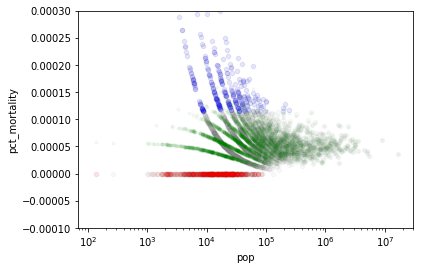

In [14]:
scatter_plot_cancer_rates(df, theta_post_mean)
plt.show()

## Problem 4: In the Blink of a Bayesian Iris

We've done classification before, but the goal of this problem is to introduce you to the idea of classification using Bayesian inference. 

Consider the famous *Fisher flower Iris data set* a  multivariate data set introduced by Sir Ronald Fisher (1936) as an example of discriminant analysis. The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, you will build a model to predict the species. 

For this problem only consider two classes: **virginica** and **not-virginica**. 

The iris data can be obtained [here](./iris.csv).

Let $(X, Y )$ be our dataset, where $X=\{\vec{x}_1, \ldots \vec{x}_n\}$ and $\vec{x}_i$ is the standard feature vector corresponding to an offset 1 and the four components explained above. $Y \in \{0,1\}$ are the scalar labels of a class. In other words the species labels are your $Y$ data (virginica = 0 and virginica=1), and the four features -- petal length, petal width, sepal length and sepal width -- along with the offset make up your $X$ data. 

The goal is to train a classifier, that will predict an unknown class label $\hat{y}$ from a new data point $x$. 

Consider the following glm (logistic model) for the probability of a class:

$$ p(y) = \frac{1}{1+e^{-x^T \beta}} $$

(or $logit(p) = x^T \beta$ in more traditional glm form)

where $\beta$ is a 5D parameter to learn. 

Then given $p$ at a particular data point $x$, we can use a bernoulli likelihood to get 1's and 0's. This should be enough for you to set up your model in pymc3. (Other Hints: also use theano.tensor.exp when you define the inverse logit to go from $\beta$ to $p$, and you might want to set up $p$ as a deterministic explicitly so that pymc3 does the work of giving you the trace).

Use a 60-40 stratified (preserving class membership) split of the dataset into a training set and a test set. (Feel free to take advantage of scikit-learn's `train_test_split`).

1. Choose a prior for $\beta \sim N(0, \sigma^2 I) $ and write down the formula for the normalized posterior $p(\beta| Y,X)$. Since we dont care about regularization here, just use the mostly uninformative value $\sigma = 10$.
2. Find the MAP and mean estimate for the posterior on the training set.
3. Implement a  sampler to sample from this posterior of $\beta$.   Generate samples of $\beta$ and plot the sequence of $\beta$'s  and histograms for each $\beta$ component.



**Solutions:**

#### Question 1. Setting up Posterior Equation
With a normal prior, our Bayesian model for logistic regression is as follows:
\begin{align}
y_j &\sim Ber(\sigma(\beta^Tx_j)), \quad j = 1, \ldots, N\\
\beta &\sim \mathcal{N}(0, 10I)
\end{align}
where $\sigma$ is the sigmoid function
$$
\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^{x}}{e^{x} + 1}.
$$

In this problem we're exploring the difference between using point estimates from the posterior distribution (like MAP or posterior mean), the entire posterior distribution and the posterior predictive distribution to inform our decisions and predictions after the inference step.  We'll contrast the effects of using different point estimates from the posterior distribution for computing the probability, $p(y_j = 1 | \beta, x_j)$. For this, we will obtain samples from the posterior $p(\beta |\{y_j\}, \{x_j\} )$. 


#### Question 2. Obtaining Point Estimates
Given our model, the posterior is
$$
p(\beta | \{y_j\}_j, \{x_j\}_j) = \frac{\prod_j p(y_j | \beta, x_j) p(\beta)}{p(\{y_j\}_j)} = \frac{\prod_j Ber(\sigma(\beta^Tx_j))\mathcal{N}(0, 10I)}{\int \prod_j  Ber(\sigma(\beta^Tx_j))\mathcal{N}(0, 10I) d\beta}
$$
Note that while we can compute, using the expression above, the MAP and mean of the posterior distribution, there is not an easy closed form expression for the posterior predictive and sampling from this posterior by hand will also be difficult.

**Preping the Data**

In [74]:
#Read data
df = pd.read_csv('iris.csv', skipinitialspace=True)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [77]:
#For converting classification 'Iris-virginica' to 1 and the rest to 0
d = {'Iris-setosa': 0, 'Iris-versicolor': 0, 'Iris-virginica':1}
#Feature dimensions, with bias
D = df.shape[1]
#Number of data points
N = df.shape[0]
#Number of samples
n_samples = 5000

#Train, test split
x_train, x_test, y_train, y_test = train_test_split(np.append(np.ones((df.shape[0], 1)),df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values, axis=1), 
                                                    df['class'].replace(d).values, 
                                                    test_size=0.4)

**Setting Up the Model in Pymc3**

In [97]:
#Input
x_shared = shared(x_train)
#Target
y_shared = shared(y_train)

#Instantiate pymc3 model
logistic_model = pm.Model()

#Set up model
with logistic_model:
    #Prior
    betas = pm.Normal('betas', 0, tau=1/100 , shape=(D, ))
    
    #p(y_j=1 | beta, x_j)
    p = pm.math.invlogit(t.dot(x_shared, betas))
    
    #Likelihood
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_shared)
    

**Finding the Estimates**

In [129]:
beta_map = find_MAP(model=logistic_model)
print(beta_map)

logp = -22.026, ||grad|| = 0.012721: 100%|██████████| 38/38 [00:00<00:00, 2263.04it/s]  

{'betas': array([-10.47553147,  -3.388661  ,  -2.93667342,   5.10897384,
         8.81881967])}


Our MAP estimate is:

$$\beta_{MAP} =[-10.47553147,  -3.388661  ,  -2.93667342,   5.10897384, 8.81881967]$$

Our mean estimate (calculated below) is:

$$\beta_{MAP} =[-12.93613158  -4.81385222  -3.67415064   7.11943131  10.97103734]$$

**Sampling from the Model**

In [ ]:
#Sampling from model
with logistic_model:
    step = pm.NUTS(scaling = beta_map)
    trace = sample(n_samples, step=step, start=beta_map, random_seed=123)

#### Sampling Diagnostics: Trace and Autocorrelation Plots

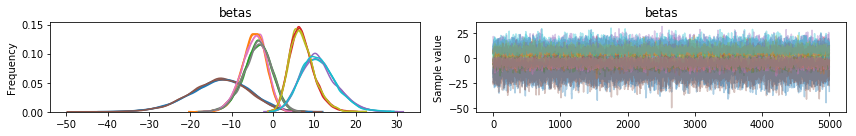

In [90]:
#Traceplots
traceplot(trace)
plt.show()

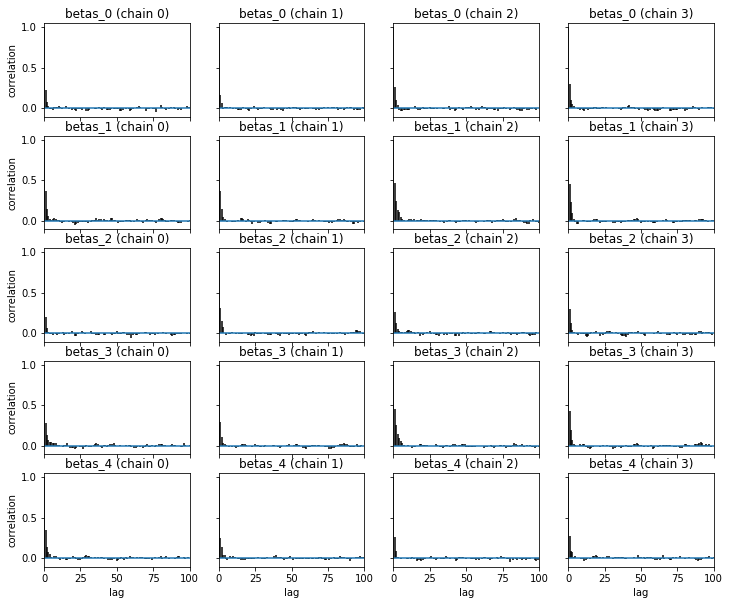

In [91]:
#Autocorrelation plots
pm.autocorrplot(trace)
plt.show()

From the diagnostic plots, it looks like our sampler has mixed. Now, from these samples of $\beta$, we want to compute the posterior mode (MAP) and posterior mean.

#### Point Estimates

In [128]:
#Sigmoid function
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

#Dot product of x and beta
beta_coef = lambda x, beta: x.dot(beta)

#Posterior mean of beta
beta_mean = trace['betas'].mean(axis=0)

print("Our estimate for posterior beta mean: {}".format(beta_mean))

#p(y | beta, x) using posterior mean
p_y_mean = sigmoid(beta_coef(x_train, beta_mean))
#p(y | beta, x) using posterior mode
p_y_MAP = sigmoid(beta_coef(x_train, MAP['betas']))
#p(y | beta, x) using all posterior samples, that is, we have 5000 p's for
#each training x
p_y_post = sigmoid(beta_coef(x_train, trace['betas'].T))

#Find the training x with p(y | beta_MAP, x) closest to 0.5
indx = np.argmin(np.abs(p_y_MAP - 0.5))


## Find some training x with maps further from 0.5
indices = np.argsort(np.abs(p_y_MAP - 0.5))
indx2 = indices[5]
indx3 = indices[29]


Our estimate for posterior beta mean: [-12.93613158  -4.81385222  -3.67415064   7.11943131  10.97103734]


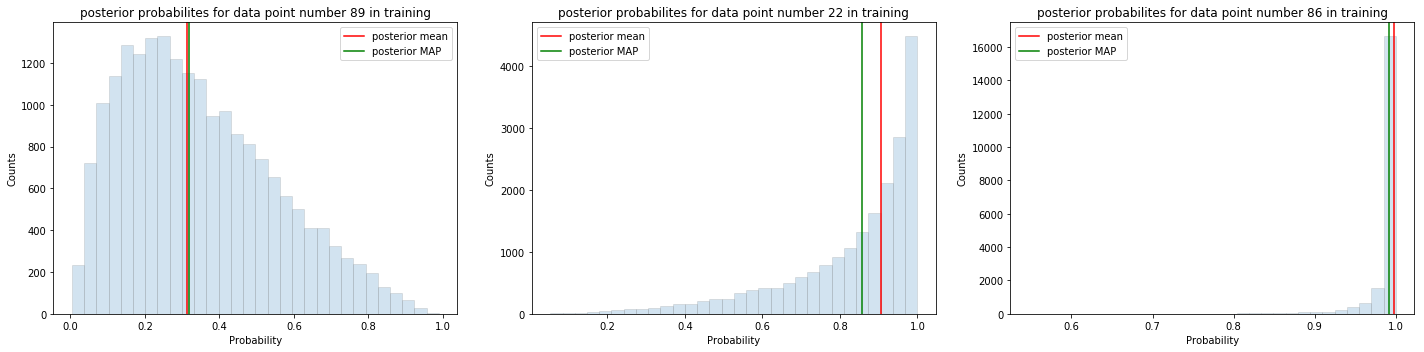

In [135]:
#Plot the various p(y | beta, x) for three training data points
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

#Plot for training x with p(y | beta_MAP, x) closest to 0.5
ax[0].hist(p_y_post[indx, :], bins=30, edgecolor='gray', linewidth='1', alpha=0.2)
ax[0].axvline(x=p_y_mean[indx], color='red', label='posterior mean')
ax[0].axvline(x=p_y_MAP[indx], color='green', label='posterior MAP')
ax[0].set_title('posterior probabilites for data point number ' + str(indx) + ' in training')
ax[0].legend(loc='best')
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Probability')

#Plot for training #7
ax[1].hist(p_y_post[indx2, :], bins=30, edgecolor='gray', linewidth='1', alpha=0.2)
ax[1].axvline(x=p_y_mean[indx2], color='red', label='posterior mean')
ax[1].axvline(x=p_y_MAP[indx2], color='green', label='posterior MAP')
ax[1].set_title('posterior probabilites for data point number ' + str(indx2) + ' in training')
ax[1].legend(loc='best')
ax[1].set_ylabel('Counts')
ax[1].set_xlabel('Probability')

#Plot for traning #80
ax[2].hist(p_y_post[indx3, :], bins=30, edgecolor='gray', linewidth='1', alpha=0.2)
ax[2].axvline(x=p_y_mean[indx3], color='red', label='posterior mean')
ax[2].axvline(x=p_y_MAP[indx3], color='green', label='posterior MAP')
ax[2].set_title('posterior probabilites for data point number ' + str(indx3) + ' in training')
ax[2].legend(loc='best')
ax[2].set_ylabel('Counts')
ax[2].set_xlabel('Probability')
plt.tight_layout()
plt.show()

### Conclusions:

Immediately, we observe two things:
1. the posterior mean and the posterior mode (MAP) estimates of the model parameters can be quite different
2. point estimates alone do not capture all the important features in the posterior distribution. In particular, they fail to give us a sense of how "certain" these estimates are or how much confidence we can place in them. For example, from the distribution of $p$'s arising from the posterior samples of $\beta$ for data point \#38, we see that we have less reason to be confident in our estimate of  $p(y_{89} = 1 | x_{89}, \beta)$; where as, in contrast, we have more reason to be confident in our estimate of $p(y_{86} = 1 | x_{86}, \beta)$.

Note that our ultimate task is to classify a data point as either 0 (not Iris-virginica) or 1 (Iris-virginica). Computing a probability $p(y_{j} = 1 | x_{j}, \beta)$ alone does not determine this classification. What we need is a method of producing a binary classification given an estimate $p(y_{j} = 1 | x_{j}, \beta)$. Then, we need to investigate the effect of our choices of estimtates of $\beta$ on the quality of our classification (for example, by looking at misclassifcation rates). This is precisely what we will study in Part B.